In [1]:
import pandas as pd
import os
from trading_strategy_season import run_strategy, plot_trades_by_year, compute_basic_metrics, plot_equity_and_drawdown
from yearly_return import evaluate_seasonal_strategy, pretty_print_result, \
                    compute_seasonal_returns, plot_seasonal_returns, compute_seasonal_return_by_year, \
                    pretty_print_seasonal_by_year,plot_seasonal_return_by_year




# Chiến lược giao dịch

Dựa trên phân tích trước về đặc điểm của cổ phiếu Coca-Cola, ta ghi nhận một số điểm quan trọng:

- Không có xu hướng mạnh: ADX thấp và autocorrelation âm cho thấy giá không duy trì trend dài hạn

- Mean-reversion cũng không quá rõ ràng: không đủ mạnh để xây dựng chiến lược mean-reversion độc lập.

- Mùa vụ rõ rệt: Hiệu ứng mùa vụ thể hiện khá ổn định — cổ phiếu thường mạnh vào quý Q3 và Q4, đặc biệt các tháng 3 / 9 / 11, trong khi tháng 1 thường yếu.

Từ các quan sát này, ta quyết định thiết kế một chiến lược mùa vụ ngắn hạn dựa trên quy luật phân tích ở trên


## Chiến lược giao dịch dựa trên Pattern seasonality

Chiến lược này chỉ hoạt động trong 2 giai đoạn: Tháng 3 - Tháng 5 và Tháng 9 - Tháng 11

**1. Mua Ban Đầu (Entry)**

- Thời điểm: Ngày giao dịch đầu tiên của tháng (ví dụ: ngày 1/3, 1/9)
  
- Hành động: MUA tại Giá Mở Cửa (OPEN).

**2. Chu Kỳ Thoát/Vào Lại (Buy-Sell Cycle)**

Mỗi ngày, hãy kiểm tra Giá Đóng Cửa (CLOSE) so với Giá Mua Ban Đầu (Entry Price) của vị thế hiện tại:

- Nếu Lời $\ge 5\%$ HOẶC Lỗ $\le -5\%$:
  
    - BÁN tại Giá Mở Cửa (OPEN) của NGÀY HÔM SAU.
      
    - Sau đó, MUA LẠI ngay tại Giá Đóng Cửa (CLOSE) của chính ngày bán đó.

**3. Kết Thúc Giai Đoạn (Exit)**

- Thời điểm: Ngày giao dịch cuối cùng của tháng 5 hoặc tháng 11.
  
- Hành động: Luôn BÁN tại Giá Mở Cửa (OPEN) của ngày cuối cùng đó để kết thúc vị thế và chờ đợi mùa giao dịch tiếp theo

In [2]:
# Đường dẫn folder chứa dữ liệu
base_folder = r'C:\\Users\\Dinh Binh An\\OneDrive\\Dai_hoc\\toan_tai_chinh\\giua_ki\\Data'

# Đường dẫn file
file_path = os.path.join(base_folder, 'KO.csv')

df_main = pd.read_csv(file_path, parse_dates=['Date'])
df_main = df_main.sort_values('Date').reset_index(drop=True)

print(f"Data shape: {df_main.shape}")
print(f"Date range: {df_main['Date'].min()} to {df_main['Date'].max()}")

Data shape: (5030, 8)
Date range: 2005-10-03 00:00:00-04:00 to 2025-09-30 00:00:00-04:00


In [3]:
start_date = df_main['Date'].min()
split_date = start_date + pd.DateOffset(years=10)


# Dữ liệu cho validation
df_val = df_main[df_main['Date'] >= split_date].copy()


print("\nBacktest:")
print(f"  Shape: {df_val.shape}")
print(f"  Date range: {df_val['Date'].min()} → {df_val['Date'].max()}")





Backtest:
  Shape: (2512, 8)
  Date range: 2015-10-05 00:00:00-04:00 → 2025-09-30 00:00:00-04:00


            entry_date           exit_date  entry_price  exit_price  shares  \
0  2016-03-01 05:00:00 2016-03-14 04:00:00    31.680406   33.149211    3156   
1  2016-03-14 04:00:00 2016-05-31 04:00:00    33.333210   33.105053    3138   
2  2016-09-01 04:00:00 2016-11-30 05:00:00    32.046230   30.914800    3241   
3  2017-03-01 05:00:00 2017-05-09 04:00:00    31.676351   33.386015    3163   
4  2017-05-09 04:00:00 2017-05-31 04:00:00    33.096958   34.557451    3190   
5  2017-09-01 04:00:00 2017-11-30 05:00:00    35.002905   35.180975    3149   
6  2018-03-01 05:00:00 2018-04-18 04:00:00    33.591052   35.302846    3298   
7  2018-04-18 04:00:00 2018-05-03 04:00:00    34.996204   33.195684    3326   
8  2018-05-03 04:00:00 2018-05-31 04:00:00    32.936218   33.966212    3352   
9  2018-09-04 04:00:00 2018-09-21 04:00:00    35.379278   37.312227    3218   
10 2018-09-21 04:00:00 2018-11-07 05:00:00    37.264229   39.512235    3222   
11 2018-11-07 05:00:00 2018-11-30 05:00:00    39.496

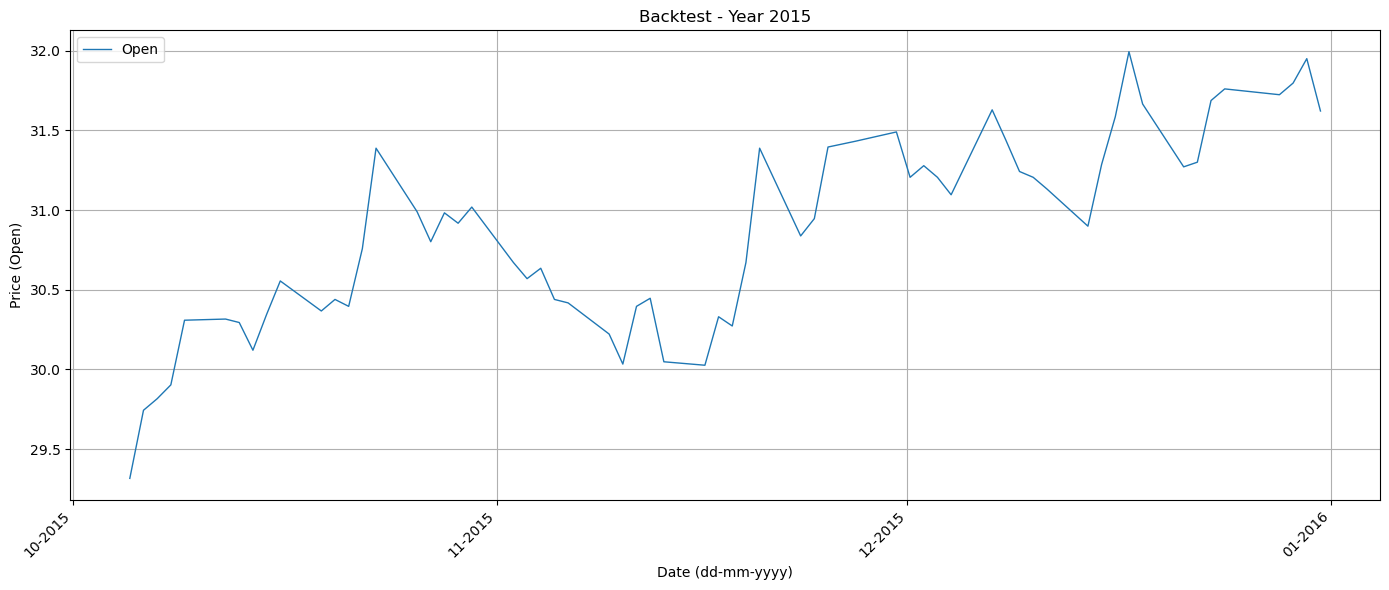

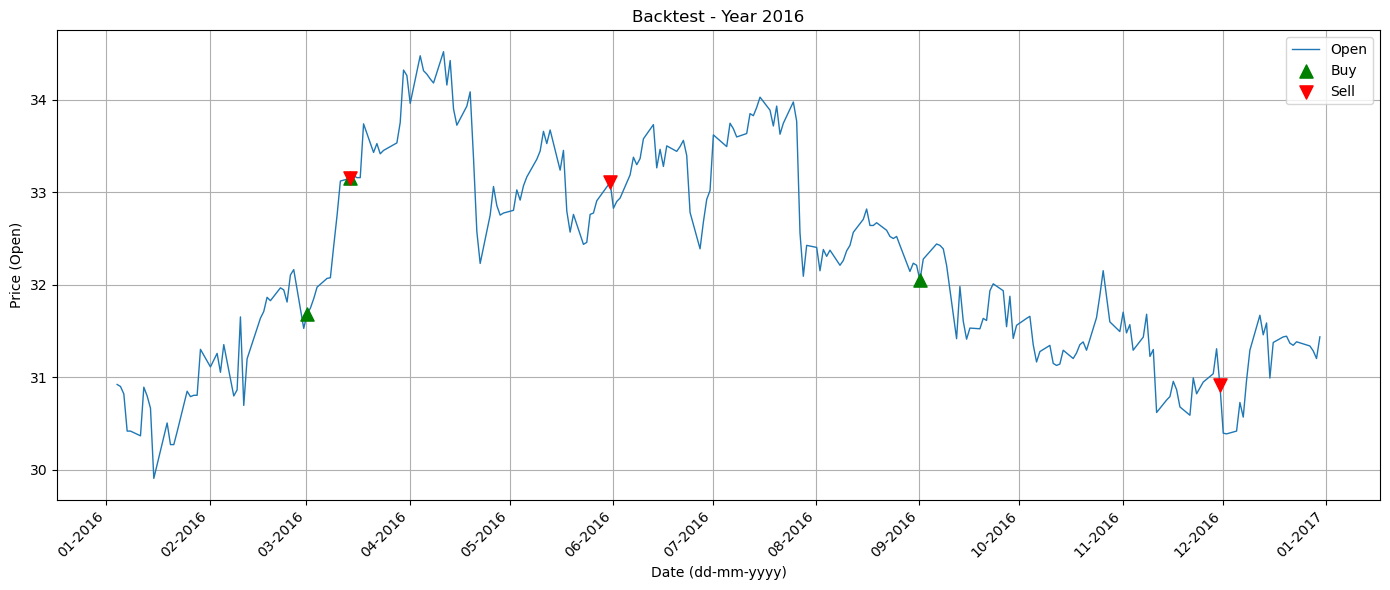

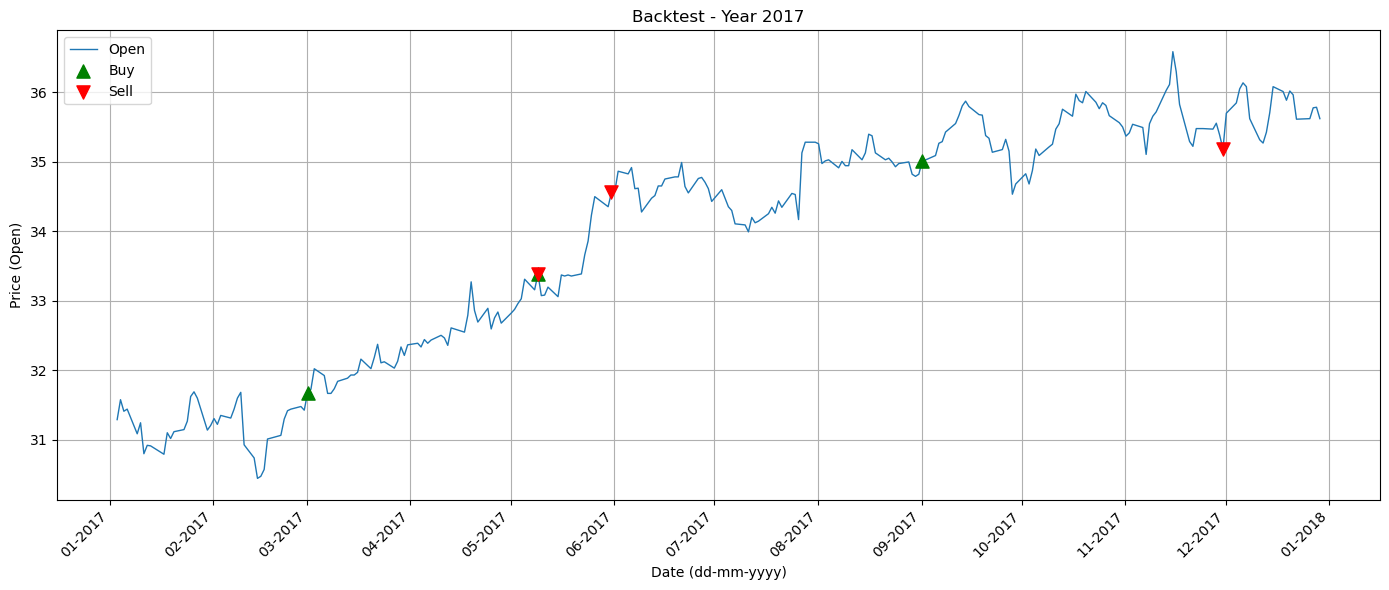

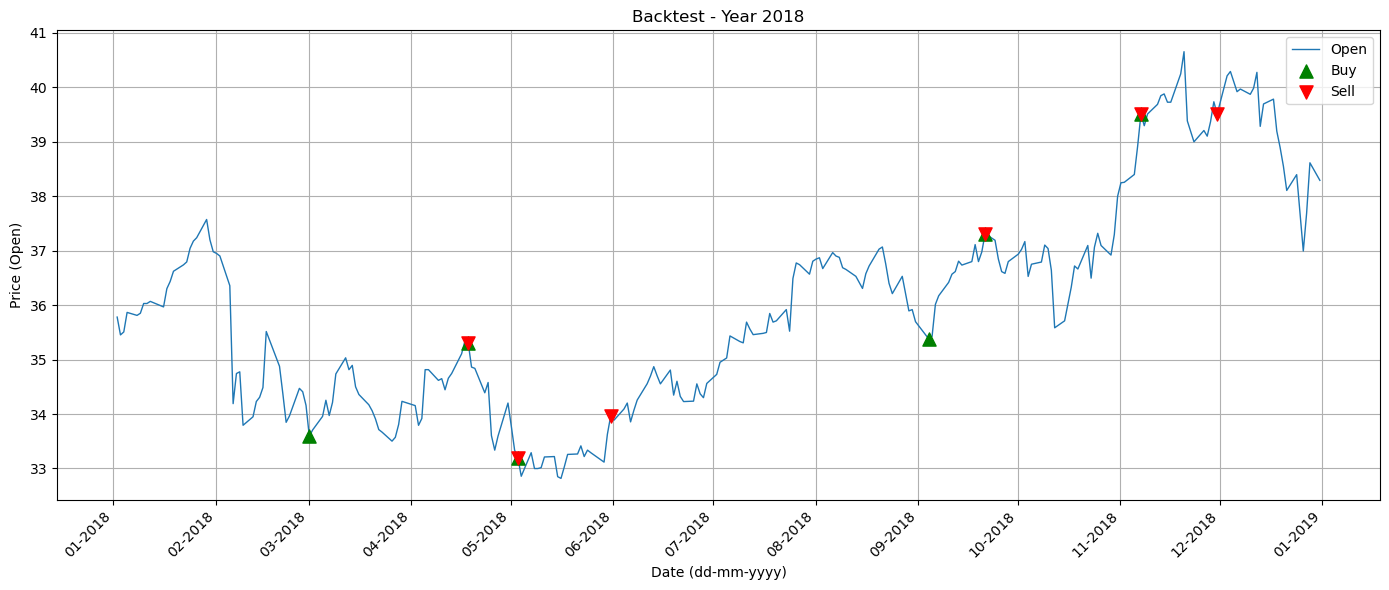

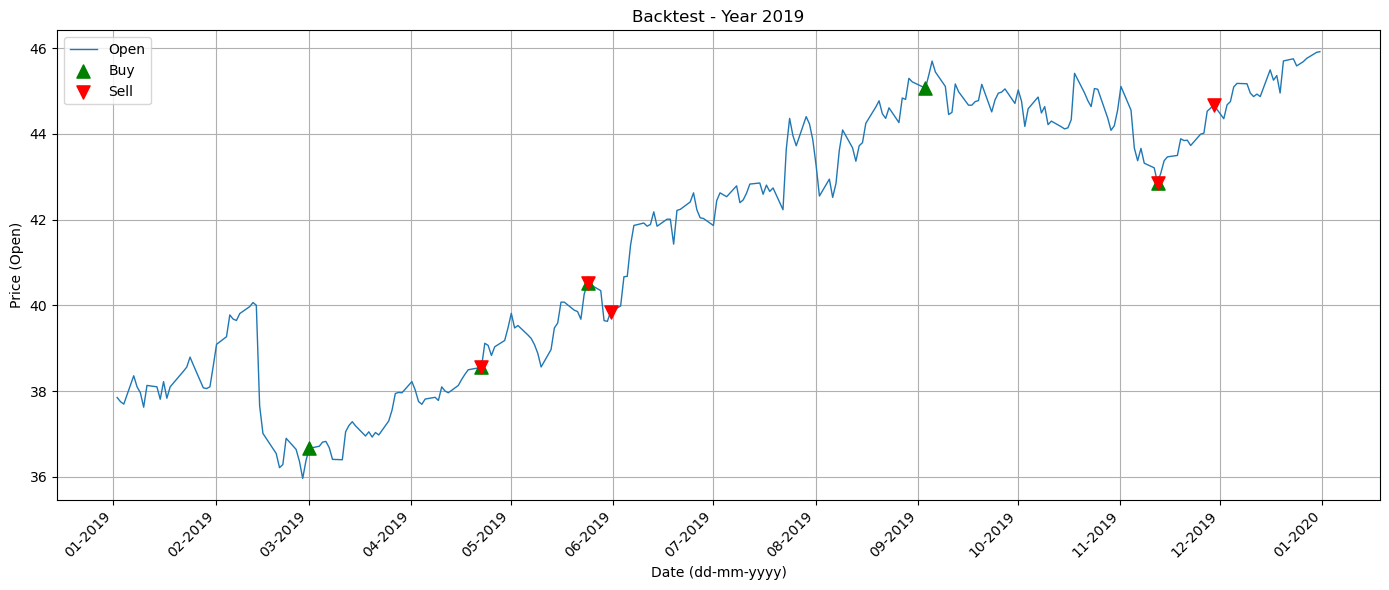

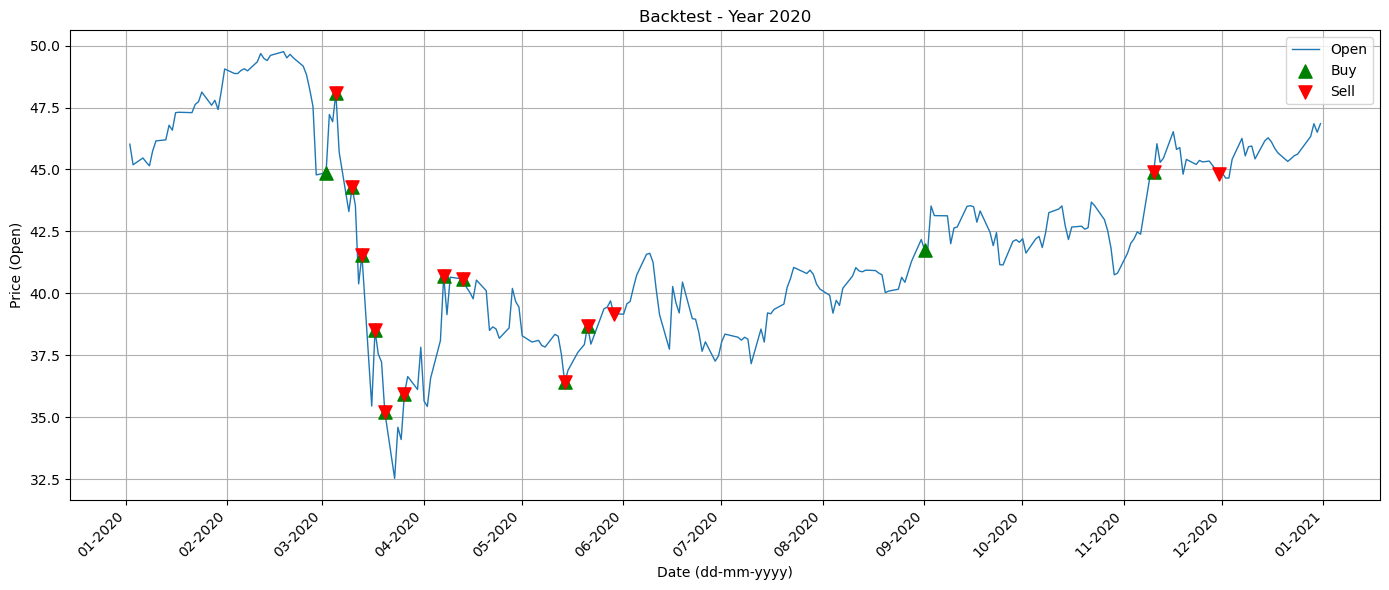

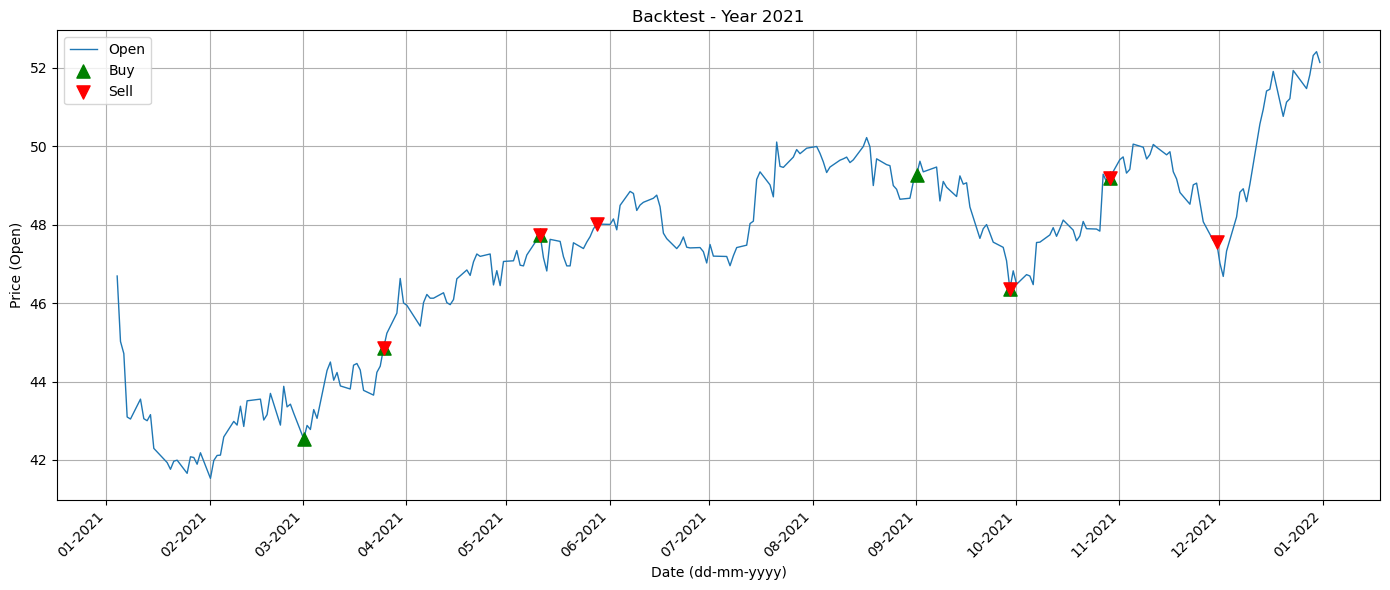

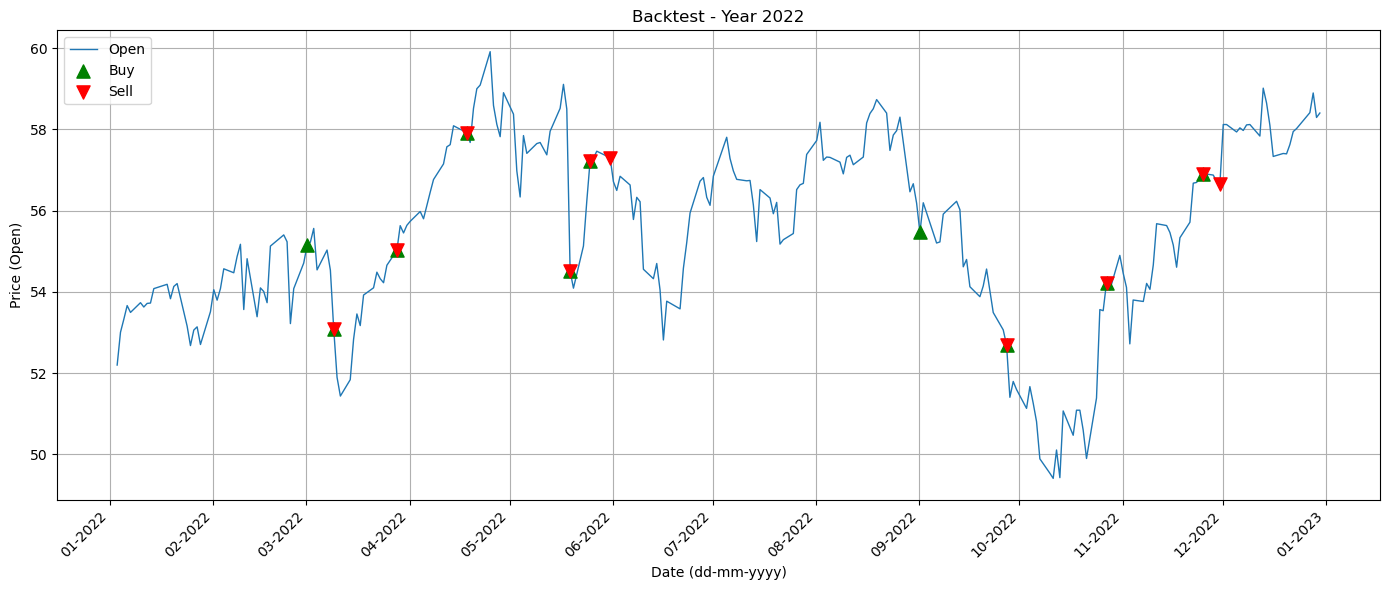

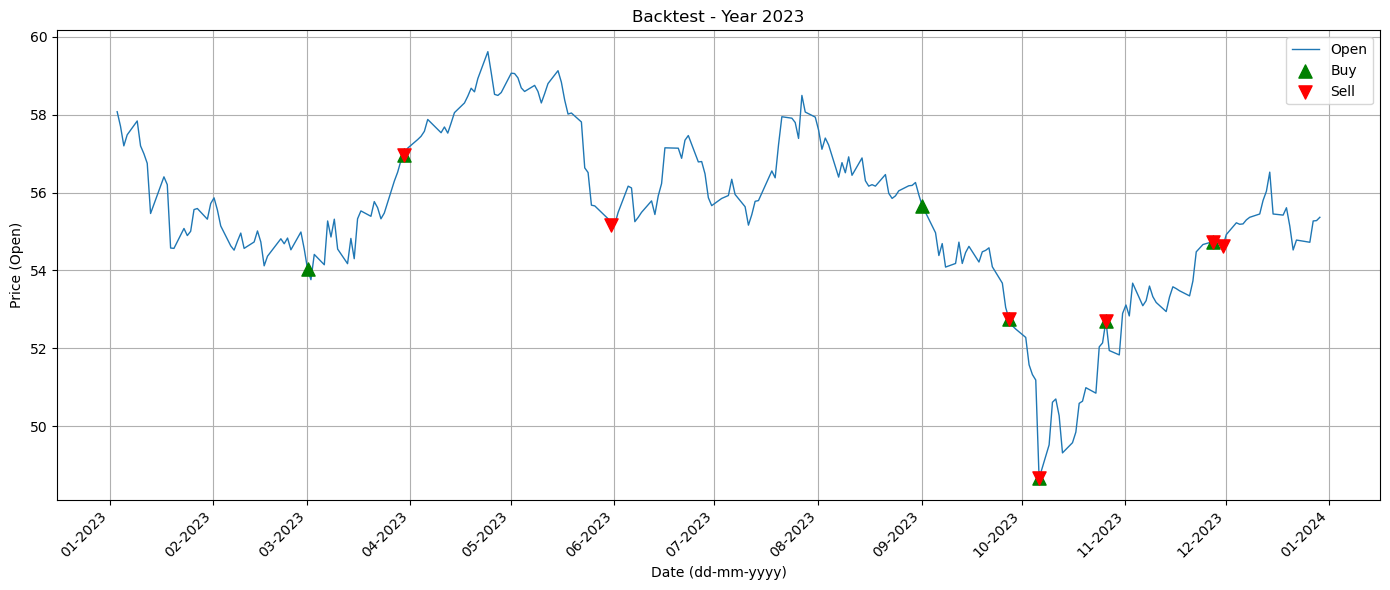

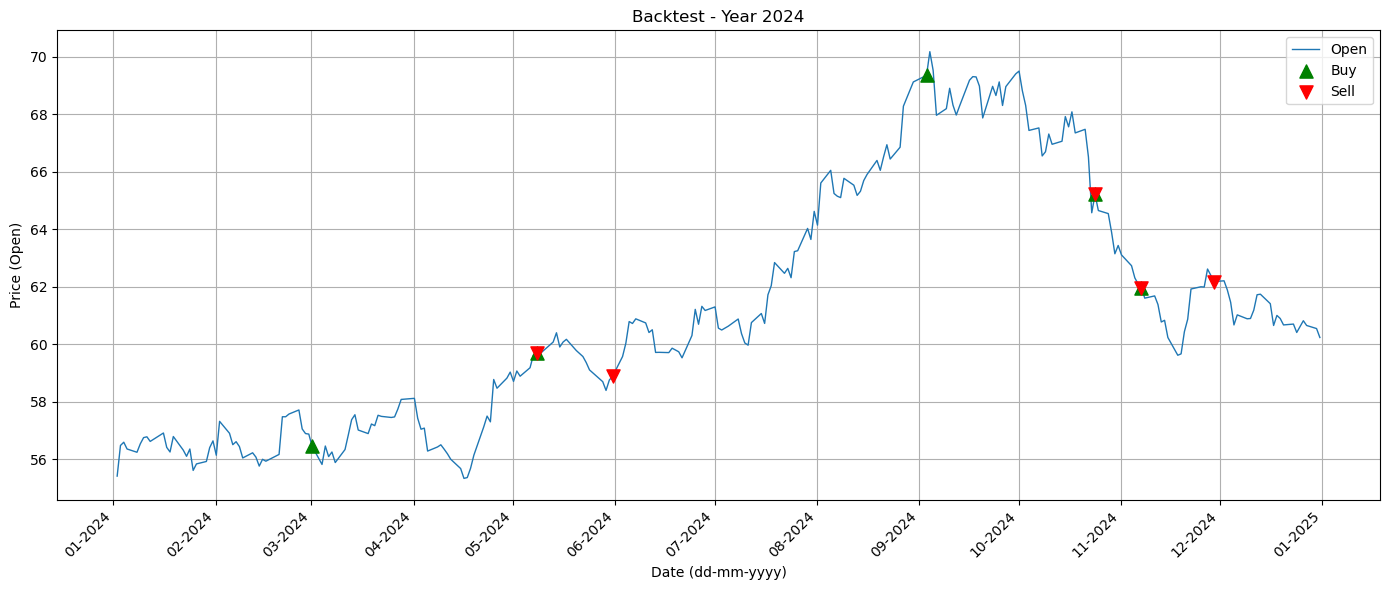

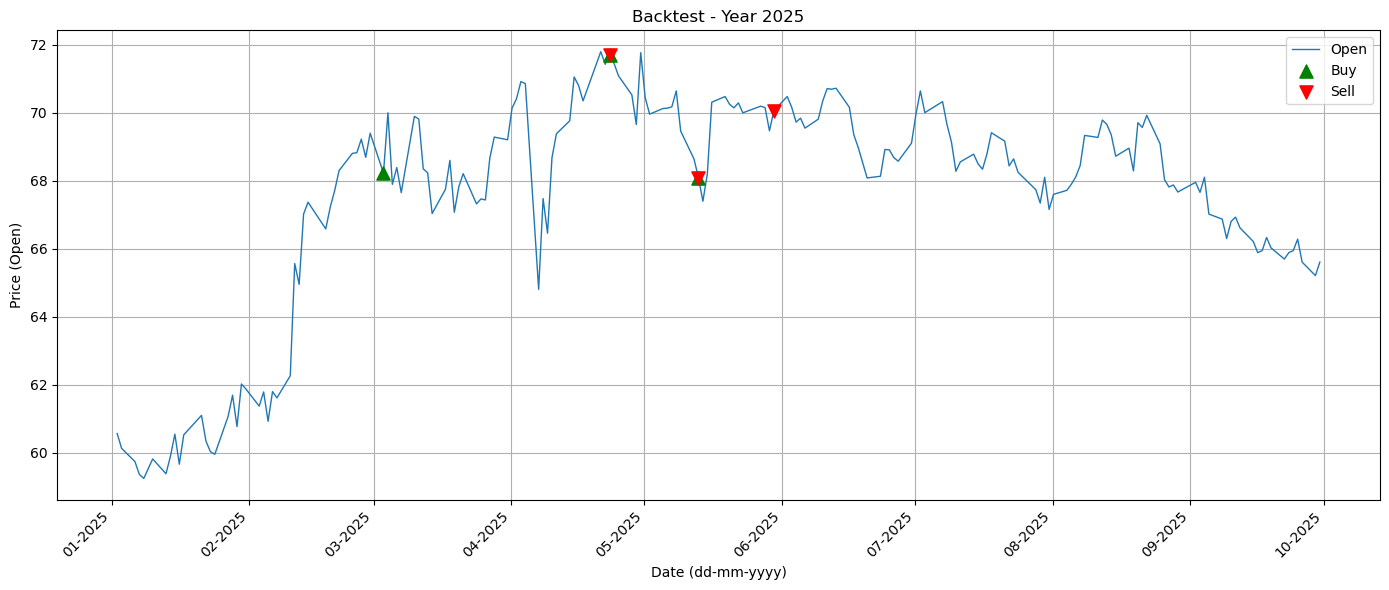

In [4]:

# Gọi backtest
trades_df_val = run_strategy(df_val, initial_capital=100000, stop_loss=-0.05, take_profit=0.05)

# Kiểm tra kết quả
print(trades_df_val.head(20))
print("Total trades:", len(trades_df_val))
if not trades_df_val.empty:
    print("Final capital (last trade):", trades_df_val['capital_after'].iloc[-1])
    print("Cumulative return % (approx):", (trades_df_val['capital_after'].iloc[-1] / 100000 - 1) * 100)

# Trực quan lịch sử giao dịch
plot_trades_by_year(df_val, trades_df_val)


**Ghi chú**

Vì dữ liệu có một vài năm không đủ số tháng trong giai đoạn nên chiến lược sẽ không thực hiên mua/bán trong các giai đoạn đó (VD: tháng 10 năm 2015 và tháng 9 năm 2025)

In [5]:

trades_df_val.tail(10)

,entry_date,exit_date,entry_price,exit_price,shares,return_pct,capital_after,reason
51,2023-10-26 04:00:00,2023-11-27 05:00:00,52.160389,54.741291,3244,4.948012,177580.749508,TP
52,2023-11-27 05:00:00,2023-11-30 05:00:00,54.666481,54.630486,3248,-0.065844,177439.820088,period_end
53,2024-03-01 05:00:00,2024-05-08 04:00:00,56.459050,59.713425,3142,5.764133,187619.580353,TP
54,2024-05-08 04:00:00,2024-05-31 04:00:00,59.713425,58.896345,3142,-1.368335,185052.316679,period_end
55,2024-09-03 04:00:00,2024-10-24 04:00:00,69.358869,65.216666,2668,-5.972132,173998.065994,SL
56,2024-10-24 04:00:00,2024-11-07 05:00:00,64.879257,61.977515,2681,-4.472527,166161.716596,SL
57,2024-11-07 05:00:00,2024-11-29 05:00:00,61.370174,62.185325,2707,1.328252,168335.674262,period_end
58,2025-03-03 05:00:00,2025-04-23 04:00:00,68.227074,71.715021,2467,5.112262,176920.955687,TP
59,2025-04-23 04:00:00,2025-05-13 04:00:00,71.724808,68.094532,2466,-5.061395,167921.115803,SL
60,2025-05-13 04:00:00,2025-05-30 04:00:00,67.478073,70.071115,2488,3.842792,174336.934083,period_end


In [6]:
if len(trades_df_val) > 0:
    metrics_trades_df_val = compute_basic_metrics(trades_df_val)
    for k, v in metrics_trades_df_val.items():
        print(f"{k}: {v:.2f}")
else:
    print("Không có trade nào được tạo.")

Number of trades: 61.00
Total return (%): 74.34
Win rate (%): 59.02
CAGR (%): 6.20
Max drawdown (%): -26.57


**Nhận xét**

- Tổng lợi nhuận đạt 74.34%, chứng tỏ chiến lược có khả năng sinh lời. Tỷ lệ thắng 59.02% ở mức khá, cho thấy các tín hiệu giao dịch có độ tin cậy tương đối tốt.

- Tuy nhiên, CAGR chỉ đạt 6.20% mỗi năm, trong khi mức drawdown tối đa lên tới -26.57%, cho thấy chiến lược vẫn chịu rủi ro giảm vốn tương đối lớn so với mức tăng trưởng đạt được. .


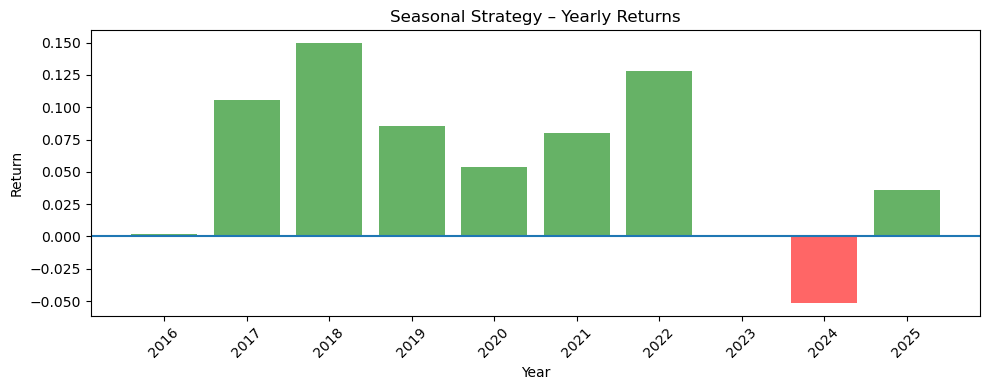

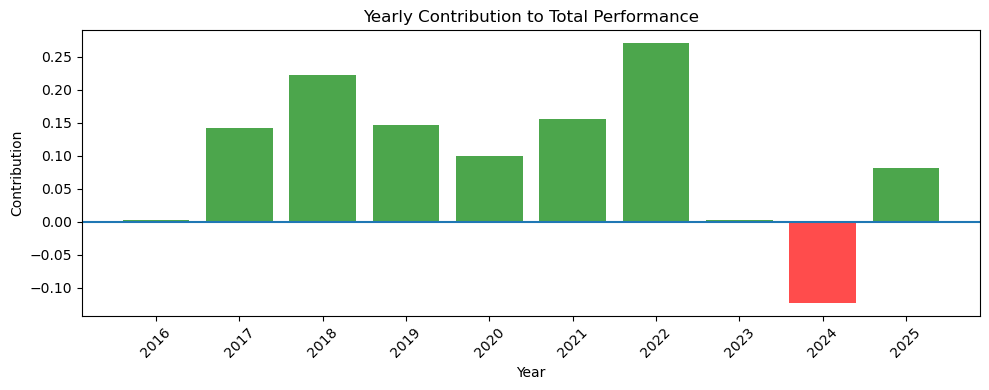

YEARLY PERFORMANCE


,return,contribution
year,,
2016,0.19%,0.26%
2017,10.57%,14.25%
2018,14.94%,22.27%
2019,8.54%,14.63%
2020,5.35%,9.94%
2021,7.97%,15.62%
2022,12.77%,27.01%
2023,0.08%,0.20%
2024,-5.13%,-12.25%



CONSISTENCY METRICS
positive_year_ratio           : 90.00%
max_year_contribution         : 27.01%


In [7]:
# Return theo từng năm

result = evaluate_seasonal_strategy(
    trades=trades_df_val,
    initial_capital=100_000,
    plot=True
)

pretty_print_result(result)


**Nhận xét**

- Positive year ratio: 90.00%

    - Khoảng 9/10 số năm có lợi nhuận dương, thể hiện sự ổn định tương đối của chiến lược qua các năm. 

    - Năm duy nhất có return âm là năm 2024, nguyên nhân có thể do yếu tố bên ngoài đó là trong năm 2024, Coca-Cola đã phải thực hiện một khoản thanh toán tạm tính lên tới 6 tỷ USD liên quan đến tranh chấp thuế kéo dài với Sở Thuế vụ Mỹ (IRS). Khoản chi phí khổng lồ này đã ảnh hưởng trực tiếp đến dòng tiền tự do (free cash flow) và tâm lý của các nhà đầu tư, khiến giá cổ phiếu bị điều chỉnh giảm.
    
- Max year contribution: 27.01%

    - Năm 2022 có lợi nhuận chiến gần 27.01% nhưng không chiếm áp đảo toàn bộ lợi nhuận nhiều năm


**Kết luận**
- Dựa trên kết quả thống kê, ta thấy chiến lược có tính ổn định và không phụ thuộc quá vào một biến động lớn trong thị trường




SEASONAL PERFORMANCE – YEAR 2016


,season,return,equity_change,contribution
0,Mar-May,3.88%,"3,884",1992.97%
1,Sep-Nov,-3.55%,"-3,689",-1892.97%


✓ Best season: Mar-May (Return 3.88%, Contribution 1992.97%)
SEASONAL PERFORMANCE – YEAR 2017


,season,return,equity_change,contribution
2,Mar-May,10.24%,"10,238",94.93%
3,Sep-Nov,0.50%,547,5.07%


✓ Best season: Mar-May (Return 10.24%, Contribution 94.93%)
SEASONAL PERFORMANCE – YEAR 2018


,season,return,equity_change,contribution
4,Mar-May,13.85%,"13,855",50.67%
5,Sep-Nov,11.85%,"13,487",49.33%


✓ Best season: Mar-May (Return 13.85%, Contribution 50.67%)
SEASONAL PERFORMANCE – YEAR 2019


,season,return,equity_change,contribution
6,Mar-May,38.97%,"38,975",101.99%
7,Sep-Nov,-0.55%,-760,-1.99%


✓ Best season: Mar-May (Return 38.97%, Contribution 101.99%)
SEASONAL PERFORMANCE – YEAR 2020


,season,return,equity_change,contribution
8,Mar-May,39.38%,"39,377",86.34%
9,Sep-Nov,4.47%,"6,229",13.66%


✓ Best season: Mar-May (Return 39.38%, Contribution 86.34%)
SEASONAL PERFORMANCE – YEAR 2021


,season,return,equity_change,contribution
10,Mar-May,65.42%,"65,417",114.34%
11,Sep-Nov,-4.96%,"-8,203",-14.34%


✓ Best season: Mar-May (Return 65.42%, Contribution 114.34%)
SEASONAL PERFORMANCE – YEAR 2022


,season,return,equity_change,contribution
12,Mar-May,67.79%,"67,788",87.71%
13,Sep-Nov,5.66%,"9,502",12.29%


✓ Best season: Mar-May (Return 67.79%, Contribution 87.71%)
SEASONAL PERFORMANCE – YEAR 2023


,season,return,equity_change,contribution
14,Mar-May,81.07%,"81,070",104.69%
15,Sep-Nov,-2.00%,"-3,630",-4.69%


✓ Best season: Mar-May (Return 81.07%, Contribution 104.69%)
SEASONAL PERFORMANCE – YEAR 2024


,season,return,equity_change,contribution
16,Mar-May,85.05%,"85,052",124.46%
17,Sep-Nov,-9.03%,"-16,717",-24.46%


✓ Best season: Mar-May (Return 85.05%, Contribution 124.46%)
SEASONAL PERFORMANCE – YEAR 2025


,season,return,equity_change,contribution
18,Mar-May,74.34%,"74,337",100.00%


✓ Best season: Mar-May (Return 74.34%, Contribution 100.00%)


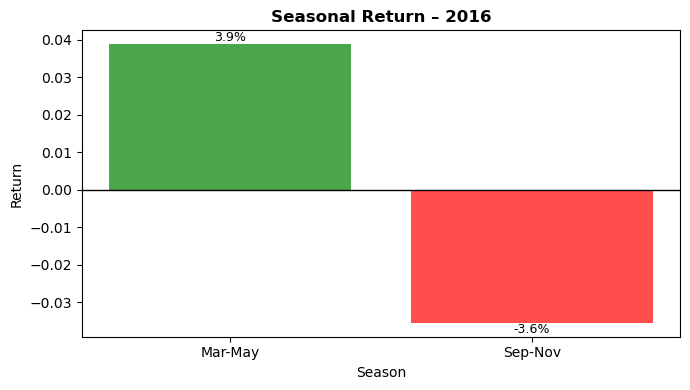

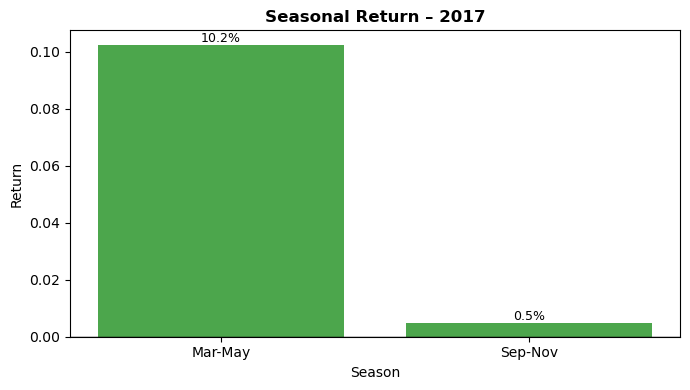

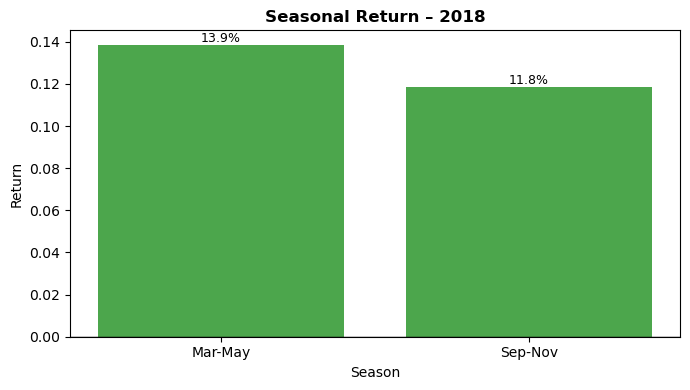

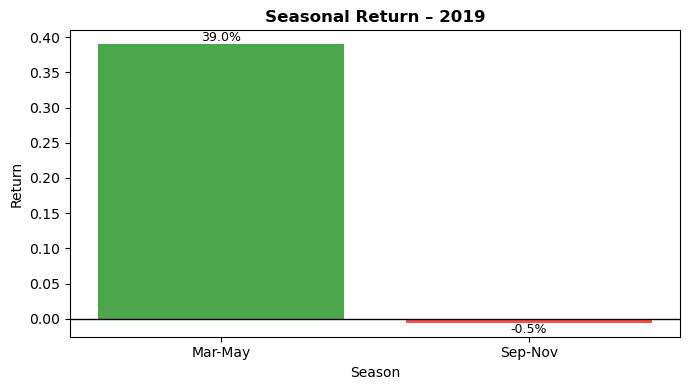

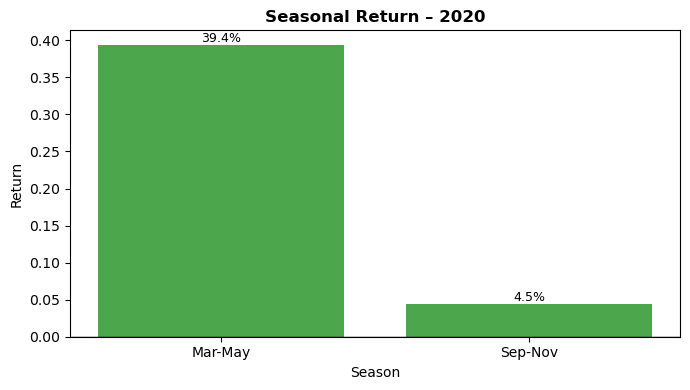

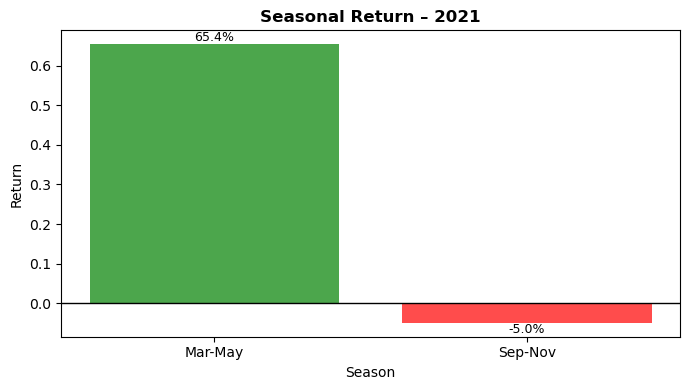

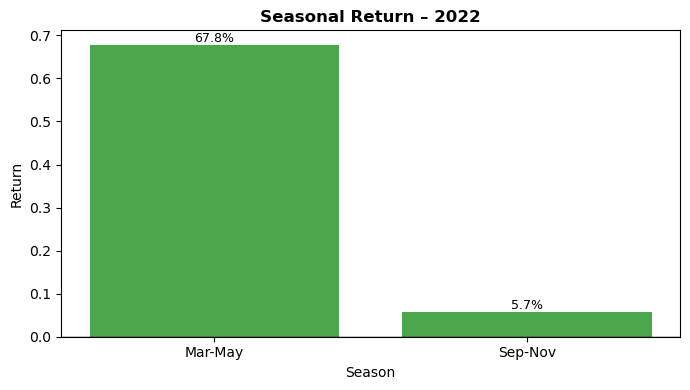

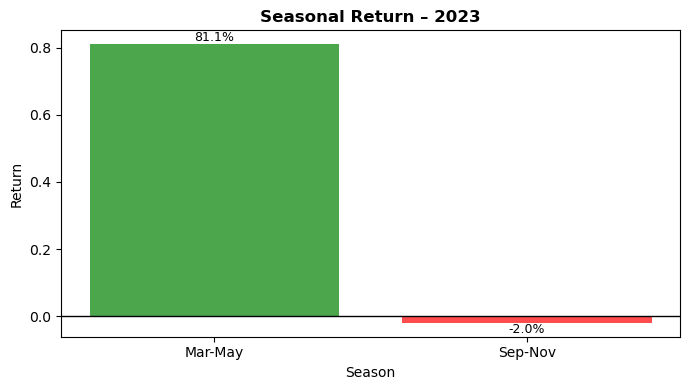

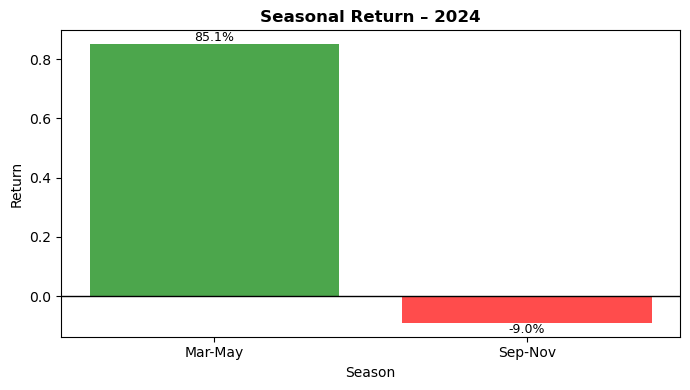

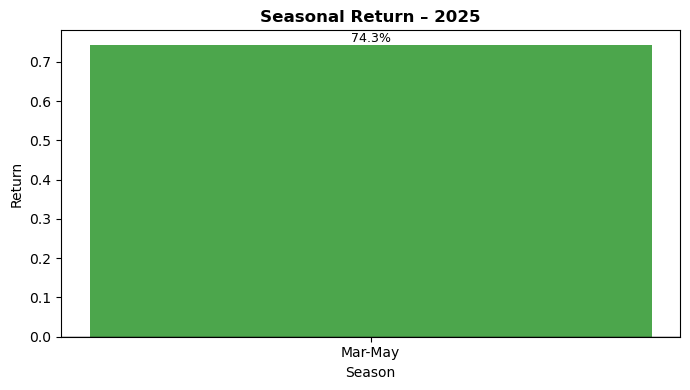

In [8]:
# % return của từng giai đoạn theo từng năm
seasonal_by_year = compute_seasonal_return_by_year(
    trades_df_val,
    initial_capital=100_000
)

# Xuất kết quả thống kê
pretty_print_seasonal_by_year(seasonal_by_year)

# Trực quan đồ thị
plot_seasonal_return_by_year(seasonal_by_year)


    season    return  equity_change
0  Mar-May  0.743369   74336.934083
1  Sep-Nov -0.034423   -6001.259821


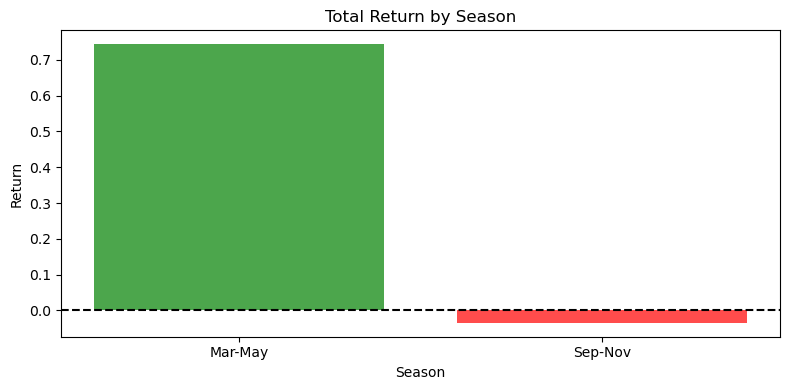

In [9]:
# Tính % return của hai giai đoạn Mar-May và Sep-Nov
seasonal_df = compute_seasonal_returns(trades_df_val, initial_capital=100000)
print(seasonal_df[["season", "return", "equity_change"]])

# Trực quan đồ thị
plot_seasonal_returns(seasonal_df)

**Nhận xét**
- Mar–May là giai đoạn tạo gần như toàn bộ lợi nhuận
- Sep–Nov không chỉ không đóng góp, mà còn làm giảm equity

=> Chiến lược hiện tại hầu hết hoạt động tốt trên giai đoạn Mar–May. Giai đoạn Sep-Nov không còn mang lại nhiều lợi nhuận

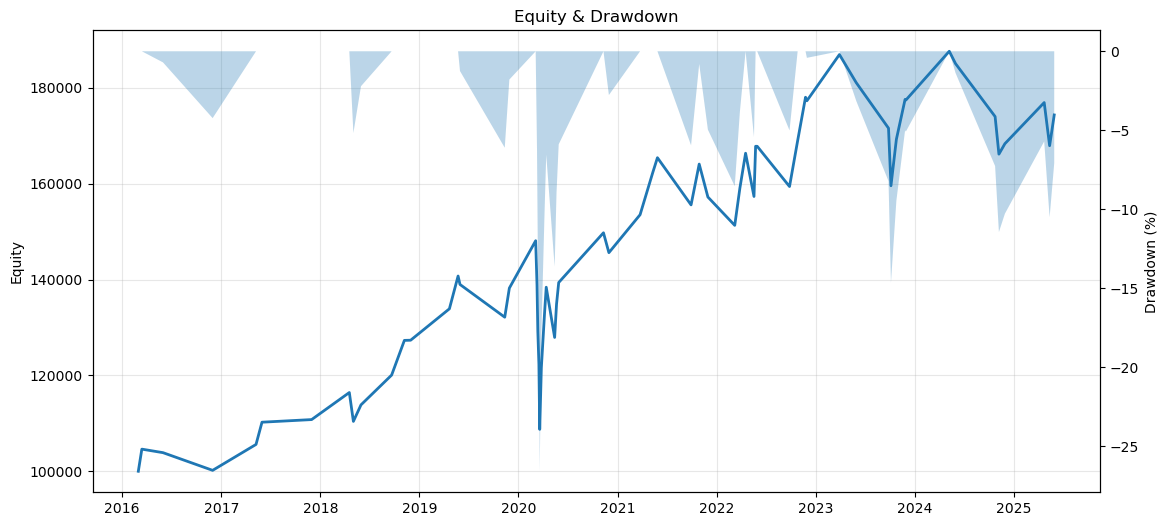

In [10]:
# Đồ thị Equity & Drawdown theo thời gian
equity, drawdown = plot_equity_and_drawdown(trades_df_val, initial_capital = 100000)


**Nhận xét**

- Drawdown lớn nhất xuất hiện vào năm 2020 (gần hơn -25%), nguyên nhân có thể là do cú sốc thị trường do đại dịch covid

- Ở các năm sau đó drawdown tương đối ổn định chỉ tầm khoảng dưới 15% đổ lại

- Sau giai đoạn có drawdown lớn nhất năm 2020, equity phục hồi nhanh và vượt đỉnh cũ, cho thấy chiến lược có khả năng chịu đựng khủng hoảng (robust), thích nghi với điều kiện thị trường thay đổi và duy trì tăng trưởng trong dài hạn.

## Nhận xét chiến lược


- Kết quả backtest cho thấy chiến lược có khả năng sinh lời và duy trì hiệu suất tương đối ổn định qua các năm, không phụ thuộc quá mức vào một giai đoạn tăng trưởng đột biến duy nhất. Tuy nhiên, mức drawdown tương đối lớn trong các giai đoạn khủng hoảng cho thấy chiến lược vẫn chịu ảnh hưởng đáng kể từ rủi ro thị trường.

- Phân tích theo mùa vụ cho thấy phần lớn lợi nhuận của chiến lược đến từ giai đoạn Mar–May, trong khi giai đoạn Sep–Nov không những không đóng góp mà còn làm suy giảm equity. Điều này cho thấy hiệu quả mùa vụ không còn đồng đều giữa các giai đoạn và chiến lược hiện tại chủ yếu hoạt động tốt trong một khoảng thời gian cụ thể trong năm.

- Nhìn chung, đây là một chiến lược đơn giản, dễ triển khai, có cơ sở thống kê rõ ràng và phù hợp cho mục tiêu đầu tư trung–dài hạn. Để nâng cao hiệu quả thực tế, chiến lược có thể tinh chỉnh thêm bằng cách tập trung vào giai đoạn Mar–May, đồng thời xem xét loại bỏ hoặc điều chỉnh giai đoạn Sep–Nov, kết hợp với tối ưu phân bổ vốn và cải thiện cơ chế quản trị rủi ro nhằm giảm drawdown trong các giai đoạn bất lợi.


